# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using a Density Forest.

## Import Libraries

In [1]:
%matplotlib inline
# python libraries
from matplotlib.patches import Rectangle
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
import sys
import pandas as pd

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from sklearn import decomposition, metrics, svm
from sklearn.utils import class_weight
from sklearn.mixture import GaussianMixture
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
#base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package
from density_tree.density_forest import *
from density_tree.plots import *
from density_tree.helpers import get_balanced_subset_indices
from helpers.plots import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8437723551972495470
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10974989517
locality {
  bus_id: 2
}
incarnation: 15001483541281187229
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1"
]


In [2]:
class_to_remove = 1

# Load Images

In [3]:
path = os.getcwd()

imgs, gt = load_data(path)

# gt to labels
# Next, we need to convert the ground truth (colors) to labels 
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

gt = gt_color_to_label(gt, colors)

colors = np.asarray(colors)/255

images: 20 
ground truth images: 20 


### Get patches

In [4]:
# Get patches
patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)

(3902, 64, 64, 4)
(964, 64, 64, 4)


# CNN Training

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [5]:
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [6]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [7]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Buildings', 'Trees', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


### Train CNN

In [8]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

<Figure size 432x288 with 0 Axes>

In [9]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [10]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### Prediction on Test Set

In [11]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# get accuracy as softmax pseudo-probability
y_pred_acc = np.max(y_pred, axis=-1)

# Get accuracy as margin between highest and second highest class
y_pred_acc_margin = get_acc_net_max_margin(y_pred)

3902/3902 [==============================] - 5s 1ms/step


In [12]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[..., np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

In [13]:
y_pred_im = [convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]

### Accuracy Metrics (Test Set)

In [14]:
# Accuracy metrics
y_pred_flattened= np.asarray(y_pred_label.flatten()).astype('int')
y_test_flattened= np.asarray(y_test_nostride.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

     Buildings      0.802     0.978     0.881    470587
         Trees      0.885     0.869     0.877    545015
         Grass      0.960     0.831     0.891    612397
     Bare Soil      0.880     0.734     0.801     66093
         Water      0.873     0.816     0.844     18705
      Railways      0.052     0.085     0.064     18526
Swimming Pools      0.000     0.000     0.000     10386

   avg / total      0.875     0.866     0.866   1741709

Overall accuracy: 86.594 %


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Certainty Assessment Methods
- Network: MSR, Margin, Entropy
- Activations
  - GMM
  - One-class SVM
  - Density Forest

## Network

In [15]:
# get all predictions in training and test set
# training set
y_pred_tr = model_unet.predict(x_train)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=class_to_remove, background=False)

# test set
y_pred_te = model_unet.predict(x_test)
y_pred_te = np.concatenate(remove_overlap(imgs, y_pred_te, ids_test, 64, 32))
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=class_to_remove, background=False)

In [16]:
# get indices of correctly / incorrectly predicted pixels
pred_t_tr = y_pred_label_tr == y_train_label
pred_f_tr = y_pred_label_tr != y_train_label

pred_t_te = y_pred_label_te == y_test_nostride
pred_f_te = y_pred_label_te != y_test_nostride

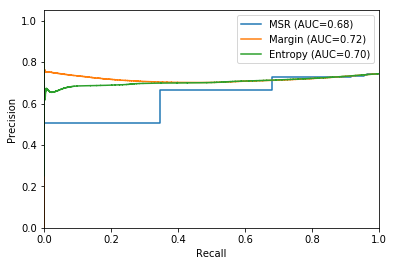

In [17]:
# precision-recall curves

# msr
y_scores = (1-get_acc_net_msr(y_pred_te)).flatten()
y_true = ((y_pred_label_te != y_test_nostride)*1).flatten()
precision_msr, recall_msr, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.auc(recall_msr, precision_msr)
roc_auc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = (1-get_acc_net_max_margin(y_pred_te)).flatten()
precision_margin, recall_margin, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.auc(recall_margin, precision_margin)
roc_auc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = (1-get_acc_net_entropy(y_pred_te)).flatten()
precision_entropy, recall_entropy, thresholds = metrics.precision_recall_curve(y_true, y_scores)
roc_auc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)
pr_auc_entropy = metrics.auc(recall_entropy, precision_entropy)

# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin,precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)'%(metrics.auc(recall_msr, precision_msr))),
            str.format('Margin (AUC=%.2f)'%(metrics.auc(recall_margin, precision_margin))),
            str.format('Entropy (AUC=%.2f)'%(metrics.auc(recall_entropy, precision_entropy)))])

## Density Forest
### Retrieve Activations, PCA, t-SNE

In [18]:
# image, layer indexes
layer_idx = -2
img_idx = 2
batch_size = 20

# get activations for training Density Forest
act_train_all = np.concatenate(get_activations(imgs, model_unet, layer_idx, x_train, ids_train, batch_size=160, patch_size=64, stride=64))

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


In [19]:
# retain only activation weights for which there is a correct prediction
act_train = act_train_all[pred_t_tr]

In [20]:
# get activations for testing Density Forest
act_test = get_activations(imgs, model_unet, layer_idx, x_test, ids_test, batch_size=160, patch_size=64, stride=32)

# remove test activations overlap
act_test = remove_overlap(imgs, np.concatenate(act_test), ids_test, patch_size=64, stride=32) 

# all labels, including background
act_test = np.concatenate(act_test, axis=0)[y_test_nostride < np.infty] # convert to 1D

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


In [21]:
# get balanced data subset to show in figure
dataset_subset_indices = get_balanced_subset_indices(y_test_nostride.flatten(), np.arange(1,9), pts_per_class=200)

In [22]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])
tsne_y = y_test_nostride.flatten()[np.concatenate(dataset_subset_indices)]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.003s...
[t-SNE] Computed neighbors for 1600 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.951126
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.115395
[t-SNE] Error after 500 iterations: 0.474636


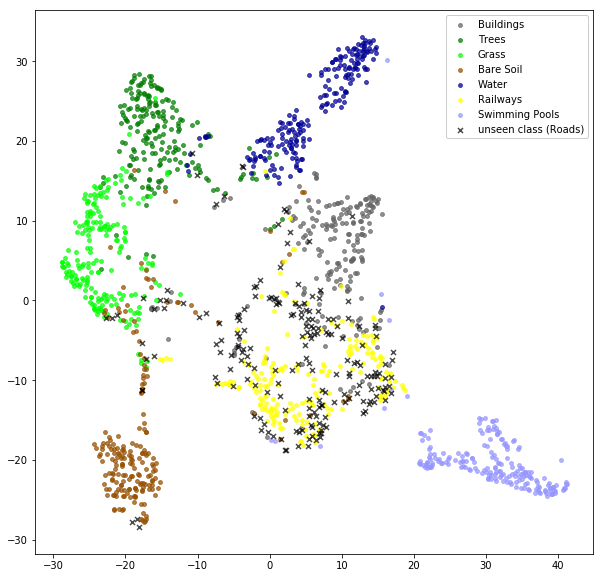

In [23]:
# plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)

In [24]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=10)
pca.fit(act_test)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform training activations
act_train = pca.transform(act_train)

# transform test set activations
act_test = pca.transform(act_test)

Variance explained by first 10 components: 0.99


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.923177
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.079884
[t-SNE] Error after 500 iterations: 0.486234


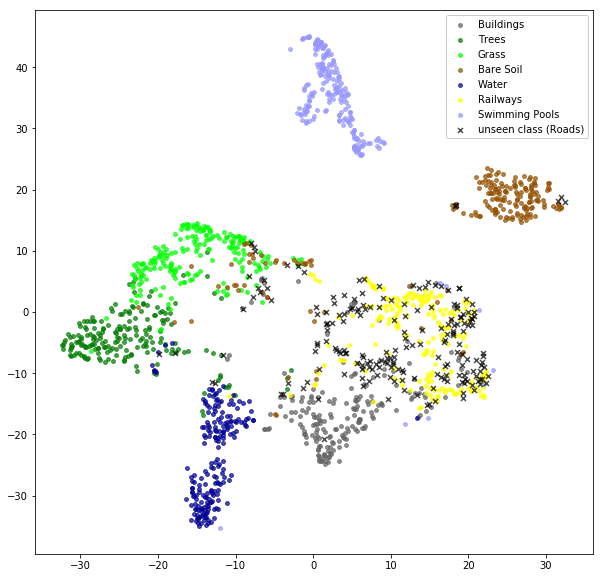

In [25]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

# plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)

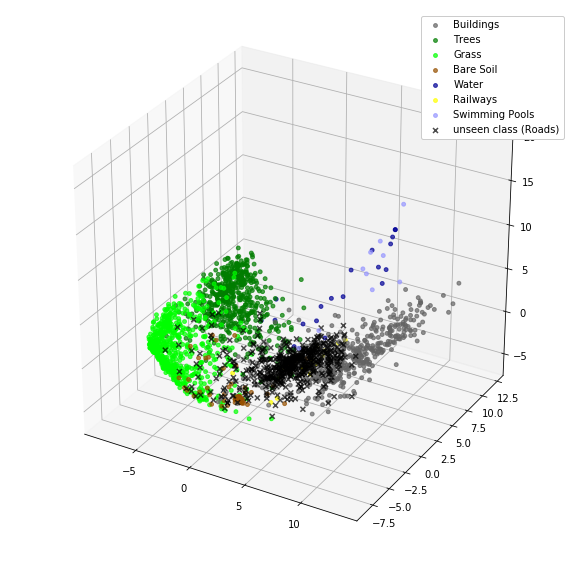

Variance explained by first 3 components: 0.90


In [26]:
# plot PCA point
plot_pts_3d(act_test[:,:3], y_test_nostride.flatten(), classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.001)

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

## GMM

In [27]:
gmm = GaussianMixture(n_components=len(classes_to_keep), max_iter=10000)

In [28]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

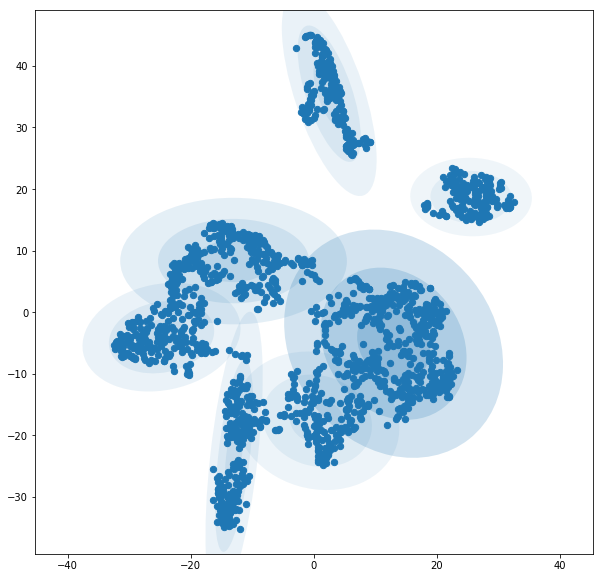

In [29]:
fig, axes = plt.subplots(1,1,figsize=(10,10)) 
plot_gmm(gmm, tsne_all, label=False, ax=axes)

In [30]:
gmm.fit(draw_subsamples(act_train,.001))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
        means_init=None, n_components=7, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [31]:
probas_gmm = gmm.predict_proba(act_test)
probas_gmm = get_acc_net_entropy(probas_gmm)

In [32]:
colors_plt = plt.cm.YlOrRd(1-probas_gmm)[:,:3][np.concatenate(dataset_subset_indices)]

In [33]:
pred_f = pred_f_te.flatten()[np.concatenate(dataset_subset_indices)]
pred_t = pred_t_te.flatten()[np.concatenate(dataset_subset_indices)]

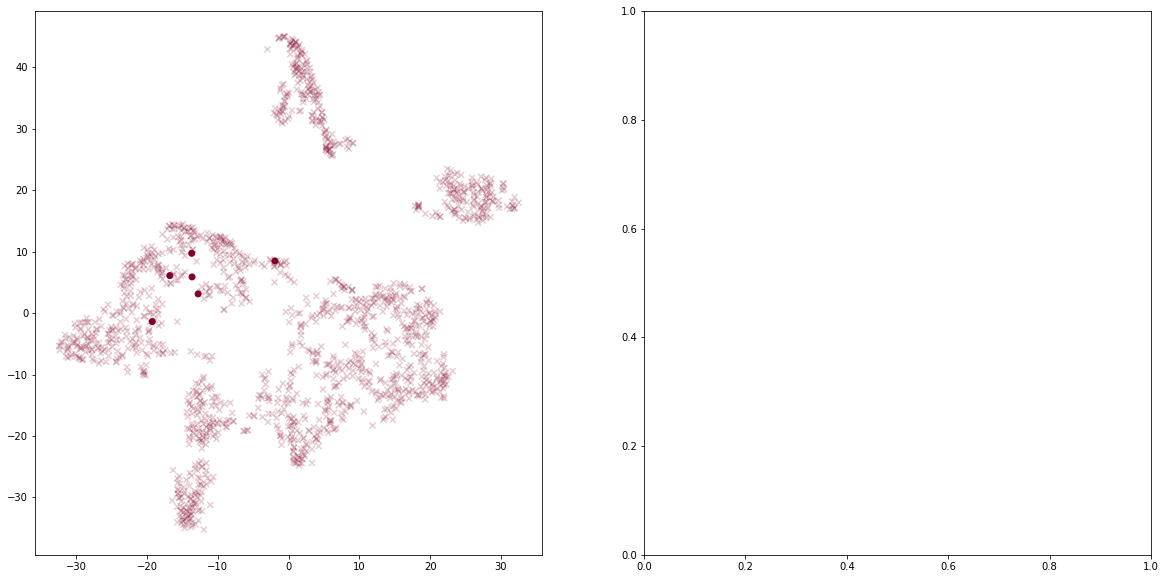

In [34]:
# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=colors_plt[pred_t]) # certainty for each point
#axes[1].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=(probas_gmm<np.sort(probas_gmm)[1000])[pred_t], alpha=.2)  # 300 least certain points in yellow

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=colors_plt[pred_f], marker='x', alpha=.2) # certainty for each point
#axes[1].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=(probas_gmm<np.sort(probas_gmm)[1000])[pred_f], marker='x')  # 300 least certain points in yellow

0.6290589846195198

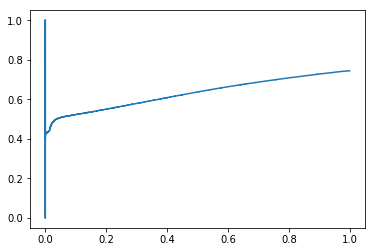

In [35]:
# precision-recall curve
y_scores = -probas_gmm
precision_gmm, recall_gmm, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
metrics.auc(recall_gmm, precision_gmm)


# SVM

In [36]:
clf_svm = svm.OneClassSVM(kernel='poly', degree=len(classes_to_keep), nu=.04)
clf_svm.fit(draw_subsamples(act_train, .001))

OneClassSVM(cache_size=200, coef0=0.0, degree=7, gamma='auto', kernel='poly',
      max_iter=-1, nu=0.04, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [37]:
probas = clf_svm.decision_function(act_test)
probas -= np.min(probas)
probas /= np.max(probas)

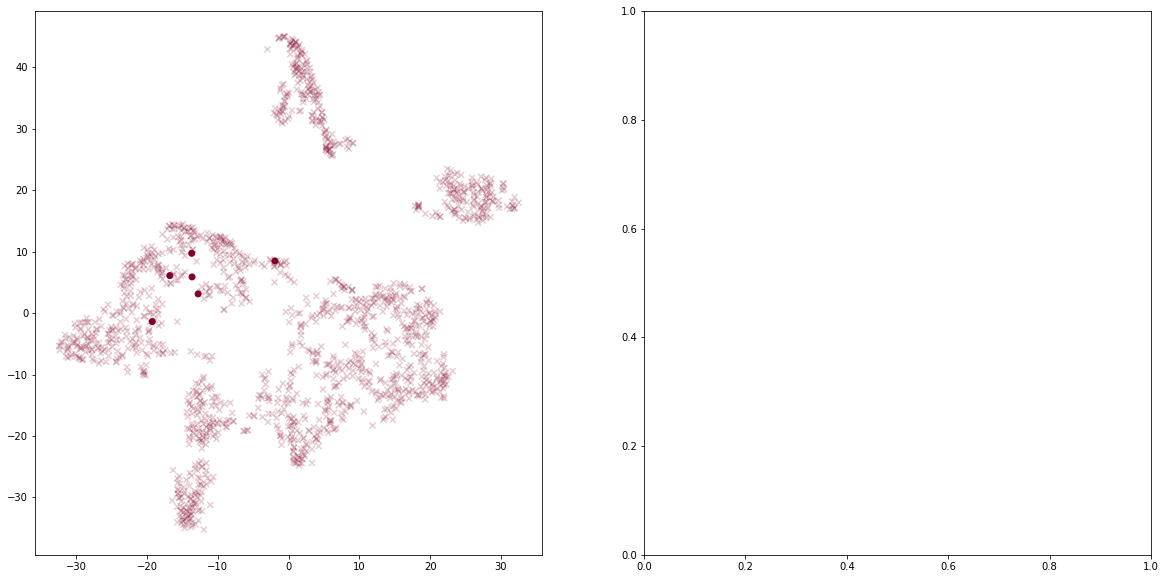

In [38]:
# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20,10)) 
axes[0].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=colors_plt[pred_t]) # certainty for each point
#axes[1].scatter(tsne_all[:,0][pred_t], tsne_all[:,1][pred_t], c=(probas_gmm<np.sort(probas_gmm)[1000])[pred_t], alpha=.2)  # 300 least certain points in yellow

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=colors_plt[pred_f], marker='x', alpha=.2) # certainty for each point
#axes[1].scatter(tsne_all[:,0][pred_f], tsne_all[:,1][pred_f], c=(probas_gmm<np.sort(probas_gmm)[1000])[pred_f], marker='x')  # 300 least certain points in yellow

0.8308329078662076

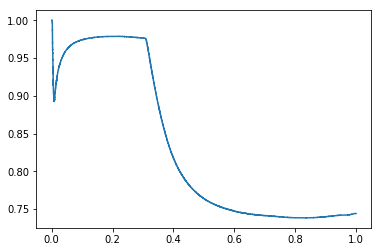

In [39]:
# precision-recall curve
y_scores = -probas
precision_svm, recall_svm, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_svm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_svm, precision_svm, where='post')
metrics.auc(recall_svm, precision_svm)

## Density Forest

**Parameters importance:**
- `n_trees`: minor relevance (10 is enough)
- `min_subset`: important, smaller number <-> more clusters (requires `subset_data` to be high enough)
- `subset_data`: irrelevant, but should be higher if `min_subset` is lower
- `max_depth`: important, greater depth <-> more clusters
- `fact_improvement`: important, smaller minimum factor <-> more clusters
- `n_max_dim`: unimportant, better to set to 0


In [40]:
n_trees = 10
max_depth = 10
subsample_pct = .002
min_subset = .1
fact_improvement = 1.4
n_max_dim = -1
n_jobs=-1

root_nodes_seen = df_create(act_train, max_depth=max_depth, min_subset=min_subset, n_trees=n_trees,
                             n_max_dim=n_max_dim, subsample_pct=subsample_pct, n_jobs=n_jobs, verbose=10, 
                             fact_improvement=fact_improvement)

Number of points on which to train each tree: 7677
Minimum number of points in each leaf: 767


[Parallel(n_jobs=40)]: Done   3 out of  10 | elapsed:    8.7s remaining:   20.3s
[Parallel(n_jobs=40)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:    9.2s remaining:    3.9s


Number of created root nodes: 10
Mean number of clusters created per tree: 14


[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   10.0s finished


In [41]:
# get probabilities for all images
probas = df_traverse_batch(act_test, root_nodes_seen, n_jobs=-1, 
                           thresh=0, batch_size=10000, verbosity=10, standardize=False)

Total steps: 394
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    5.9s
[Parallel(n_jobs=40)]: Done  65 tasks      | elapsed:    6.1s
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:    8.2s
[Parallel(n_jobs=40)]: Done 101 tasks      | elapsed:    8.7s
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 141 tasks      | elapsed:   11.7s
[Parallel(n_jobs=40)]: Done 162 tasks      | elapsed:   13.1s
[Parallel(n_jobs=40)]: Done 185 tasks      | elapsed:   14.9s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:   16.3s
[Parallel(n_jobs=40)]: Done 233 tasks      | elapsed:   18.0s
[Parallel(n_jobs=40)]: Done 258 tasks      | elapsed:   19.7s
[Parallel(n_jobs=40)]: Done 285 tasks      | elapsed:   21.5s
[Parallel(n_jobs=40)]: Done 312 tasks      | elapsed:   23.4s
[Paralle

### 4.3. Post-Treatment

In [42]:
# reshape probas to (n_patches, patch_size, patch_size)
probas_patches = np.reshape(probas, np.shape(y_test_nostride))

# transformations
probas_patches -= np.nanmin(probas_patches)
probas_patches /= np.nanmax(probas_patches)

# save probabilities corresponding to an image in an array
probas_imgs = [] # (n_imgs, n_patches, patch_size, patch_size)
for idx_im in ids_test:
    patches_start = get_offset(imgs, 64, 64, 16, idx_im) # idx of first patch in image
    patches_end = get_offset(imgs, 64, 64, 16, idx_im+1) # idx of last patch in image
    probas_im = np.asarray(probas_patches[patches_start:patches_end])
    probas_imgs.append(probas_im)

### 4.4. Figures, Tables

### Recall-Precision Curves

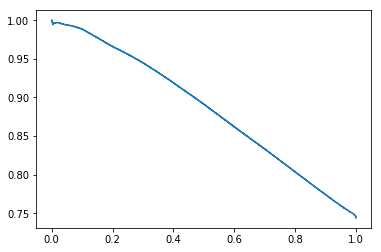

In [43]:
# DF
#y_scores = -np.log(probas_patches+1e-5).flatten()
y_scores = -probas_patches.flatten()
filt = y_test_nostride.flatten()!=0
precision_df, recall_df, thresholds = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)
plt.step(recall_df, precision_df, where='post')
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
roc_auc_df = metrics.roc_auc_score(y_true, y_scores)

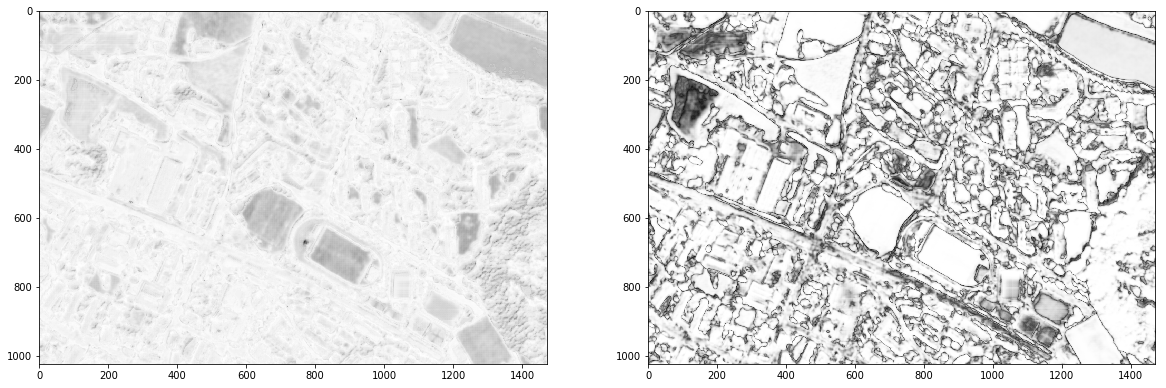

In [44]:
# show image of DF uncertainty vs. max margin uncertainty
img_idx=3
acc_im = convert_patches_to_image(imgs, probas_patches[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im = np.log(acc_im)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(acc_im[...,0], cmap='gray')
axes[1].imshow(y_pred_acc_imgs[img_idx][...,0], cmap='gray')

## Plot Results

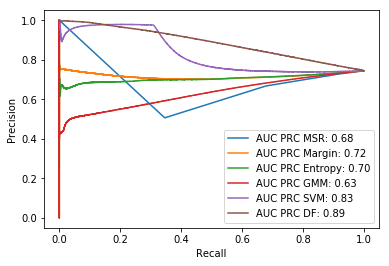

In [48]:
# Precision-Recall Curve
plt.plot(recall_msr,precision_msr)
plt.plot(recall_margin,precision_margin)
plt.plot(recall_entropy,precision_entropy)
#plt.plot(recall_dropout,precision_dropout)
plt.plot(recall_gmm,precision_gmm)
plt.plot(recall_svm,precision_svm)
plt.plot(recall_df,precision_df)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend([str.format('AUC PRC MSR: %.2f') % pr_auc_msr,
            str.format('AUC PRC Margin: %.2f') % pr_auc_margin,
            str.format('AUC PRC Entropy: %.2f') % pr_auc_entropy,
            #str.format('AUC PRC Dropout: %.2f') % pr_auc_dropout,
            str.format('AUC PRC GMM: %.2f') % pr_auc_gmm,
            str.format('AUC PRC SVM: %.2f') % pr_auc_svm,
            str.format('AUC PRC DF: %.2f') % pr_auc_df
           ])

plt.show()

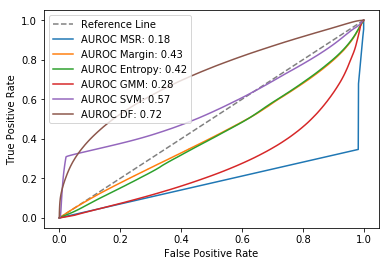

In [46]:
# ROC
plt.plot([0,1],[0,1], '--', c='gray')
plt.plot(fpr_msr,tpr_msr)
plt.plot(fpr_margin,tpr_margin)
plt.plot(fpr_entropy,tpr_entropy)
#plt.plot(fpr_dropout,tpr_dropout)
plt.plot(fpr_gmm,tpr_gmm)
plt.plot(fpr_svm,tpr_svm)
plt.plot(fpr_df,tpr_df)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Reference Line',
            str.format('AUROC MSR: %.2f') % roc_auc_msr,
            str.format('AUROC Margin: %.2f') % roc_auc_margin,
            str.format('AUROC Entropy: %.2f') % roc_auc_entropy,
            #str.format('AUROC Dropout: %.2f') % roc_auc_dropout,
            str.format('AUROC GMM: %.2f') % roc_auc_gmm,
            str.format('AUROC SVM: %.2f') % roc_auc_svm,
            str.format('AUROC DF: %.2f') % roc_auc_df
           ])

plt.show()